By default, the path to your Drive should be "/content/drive/My Drive". You may check this by clicking the file icon in
the toolbar on the left side of Colab. From there you can navigate through your file tree and copy the path of any
file in your Drive. 

Next, add the open-kbp directory to your path.

In [1]:
# Add all files to path related to open-kbp. 
# A directory 'train-pats' with all training patient data should be included in open-kbp
import sys
sys.path.append(r"C:\\ddu\\openkbp_models")


In [9]:
print(np.array(zip([1,2,3],[4,5,6])))

In [22]:

# Import provided classes and functions
%load_ext autoreload
%autoreload 2
%matplotlib inline
import shutil
from data_loader import DataLoader
from dose_evaluation_class import EvaluateDose
from general_functions import get_paths, make_directory_and_return_path
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_bool
import skimage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = np.load('batch_0.npy')
data.shape

(1, 32, 96, 128, 13)

The functions loaded from _provided\_code_ are written for this competition, and you can access them via the file 
explorer on the left hand side of the Colab window. You're welcome to change them as much as 
you'd like. Keep in mind, however, that on Colab any changes you make to the files in your Google Drive (e.g., files in
 _provided\_code_ directory) will only be recognized by Colab when the _Runtime_ is restarted via the Restart 
 Runtime option in the top toolbar. If you implement a neural network, we urge you to you start with the provided 
 network architecture and network functions. The neural network we provide is only meant to be a template, and will not 
 be a competitive model without some significant modifications.

Before we run anything, first define the paths where the provided data is stored and where the results (e.g., models, predictions) should be saved. 

In [12]:
# Define parent directory
main_data_dir = os.getcwd()
training_data_dir = '../Data/train-pats'.format(main_data_dir)
validation_data_dir = '../Data/validation-pats'.format(main_data_dir)
testing_data_dir = '../Data/test-pats'.format(main_data_dir)
training_plan_paths = get_paths(training_data_dir, ext='')  # gets the path of each plan's directory
# Define hold out set
print(training_data_dir)
training_plan_paths

../Data/train-pats


['../Data/train-pats/pt_1',
 '../Data/train-pats/pt_10',
 '../Data/train-pats/pt_100',
 '../Data/train-pats/pt_101',
 '../Data/train-pats/pt_102',
 '../Data/train-pats/pt_103',
 '../Data/train-pats/pt_104',
 '../Data/train-pats/pt_105',
 '../Data/train-pats/pt_106',
 '../Data/train-pats/pt_107',
 '../Data/train-pats/pt_108',
 '../Data/train-pats/pt_109',
 '../Data/train-pats/pt_11',
 '../Data/train-pats/pt_110',
 '../Data/train-pats/pt_111',
 '../Data/train-pats/pt_112',
 '../Data/train-pats/pt_113',
 '../Data/train-pats/pt_114',
 '../Data/train-pats/pt_115',
 '../Data/train-pats/pt_116',
 '../Data/train-pats/pt_117',
 '../Data/train-pats/pt_118',
 '../Data/train-pats/pt_119',
 '../Data/train-pats/pt_12',
 '../Data/train-pats/pt_120',
 '../Data/train-pats/pt_121',
 '../Data/train-pats/pt_122',
 '../Data/train-pats/pt_123',
 '../Data/train-pats/pt_124',
 '../Data/train-pats/pt_125',
 '../Data/train-pats/pt_126',
 '../Data/train-pats/pt_127',
 '../Data/train-pats/pt_128',
 '../Data/train

Initialize a data loader for the training set data, and use it to initialize a prediction model object. Call the
train_model method to train the model for the predefined number of epochs.

In [29]:
# Train a model
data_loader_train = DataLoader(training_plan_paths)
data_loader_train.patient_id_list
test_list = data_loader_train.patient_id_list[0]
test_data = data_loader_train.get_batch(index = 1)


['../Data/train-pats/pt_10']
../Data/train-pats/pt_10
Brainstem
ct
dose
LeftParotid
possible_dose_mask
PTV56
PTV70
RightParotid
SpinalCord
voxel_dimensions


In [10]:
print(test_data['structure_masks'].shape)
test_scale = skimage.transform.resize(image=test_data['structure_masks'], output_shape=[1,64,64,64,10])
max(test_scale.flatten())

(1, 128, 128, 128, 10)


1.0

We start by making a new data loader for the held-out set, and use it to predict (and save) a 
set of out-of-sample dose distributions. Note that we change the mode of the data loader to 'dose_prediction' to 
load only the data needed to make a prediction.


In [105]:
class IndexTracker(object):
    def __init__(self, ax, X,fig,bmin,bmax):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.fig = fig
        self.slices, row, cols = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind,:,:],cmap='jet',vmin=bmin, vmax=bmax)
        fig.colorbar(self.im, ax=self.ax )
      #  self.im.colorbar()
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind,:, :])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

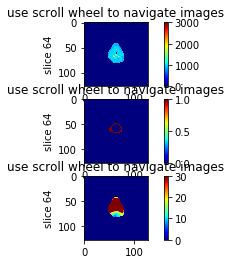

In [106]:
# Start to plot the dose and masks and show the correct 
structure = test_data['structure_masks'].squeeze()
dose = test_data['dose'].squeeze()
ct = test_data['ct'].squeeze()
structure = np.array(structure, dtype='float32')
dose = np.array(dose).astype('float32')
ct = np.array(ct).astype('float32')
structure = np.transpose(structure, axes=[2, 0, 1, 3])
dose = np.transpose(dose, axes=[2, 0, 1])
ct = np.transpose(ct, axes=[2, 0, 1])
# crop the dose outside body
mask = structure>0

### plot organ on figure 4
organ = 7
mask_organ = np.squeeze(mask[:,:,:,organ])
mask_organ = np.array(mask_organ).astype('float32')

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
tracker1 = IndexTracker(ax1, np.squeeze(ct), fig,0,3000)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, mask_organ, fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, dose, fig,0,30)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)

plt.show()                           

Load each predicted dose distribution and evaluate it against the ground truth using the 
competition metrics.

In [ ]:
# Evaluate dose metrics
data_loader_hold_out_eval = DataLoader(hold_out_plan_paths, mode_name='evaluation')  # Set data loader
prediction_paths = get_paths(dose_prediction_model_hold_out.prediction_dir, ext='csv')
hold_out_prediction_loader = DataLoader(prediction_paths, mode_name='predicted_dose')  # Set prediction loader
dose_evaluator = EvaluateDose(data_loader_hold_out_eval, hold_out_prediction_loader)
# print out scores if data was left for a hold out set
if not data_loader_hold_out_eval.file_paths_list:
    print('No patient information was given to calculate metrics')
else:
    dvh_score, dose_score = dose_evaluator.make_metrics()
    print('For this out-of-sample test:\n'
          '\tthe DVH score is {:.3f}\n '
          '\tthe dose score is {:.3f}'.format(dvh_score, dose_score))

Once you're happy with your dose distributions you can zip up the predictions with the code block below. The zipped file
will contain the dose distributions for the validation set. It can be uploaded directly to CodaLab.

In [ ]:
# Zip dose to submit
submission_dir = make_directory_and_return_path('{}/submissions'.format(results_dir))
shutil.make_archive('{}/{}'.format(submission_dir, prediction_name), 'zip', dose_prediction_model_hold_out.prediction_dir)